In [2]:
from dataclasses import dataclass
import json
from pathlib import Path
from typing import Dict, List, Set, Tuple
from collections import defaultdict

@dataclass
class ExperimentConfig:
    depths: List[int]
    hidden_sizes: List[int]
    train_sizes: List[int]
    learning_rates: List[float]

@dataclass
class ResultsData:
    nn_results: List[dict]
    ntk_results: List[dict]
    config: ExperimentConfig
    
    def filter_results(self, model_type: str, **kwargs) -> List[dict]:
        """
        Filter results based on given parameters.
        
        Args:
            model_type: Either 'nn' or 'ntk'
            **kwargs: Key-value pairs to filter on (e.g., depth=2, hidden_size=128)
            
        Returns:
            List of results matching the criteria
        """
        results = self.nn_results if model_type == 'nn' else self.ntk_results
        filtered = []
        
        for result in results:
            matches = True
            for key, value in kwargs.items():
                # Handle learning_rate/lr difference
                if key == 'learning_rate' and 'lr' in result:
                    if result['lr'] != value:
                        matches = False
                        break
                elif result.get(key) != value:
                    matches = False
                    break
            if matches:
                filtered.append(result)
                
        return filtered

class ResultsLoader:
    @staticmethod
    def _load_file(file_path: Path) -> List[dict]:
        """Load a single JSON file, handling empty files and errors."""
        try:
            with open(file_path) as f:
                content = f.read().strip()
                if not content:
                    print(f"Warning: Empty file found - {file_path}")
                    return []
                    
                results = json.loads(content)
                return results if isinstance(results, list) else [results]
                    
        except Exception as e:
            print(f"Error processing {file_path}: {str(e)}")
            return []

    @staticmethod
    def _extract_config(nn_results: List[dict], ntk_results: List[dict]) -> ExperimentConfig:
        """Extract configuration parameters from results."""
        depths = sorted(set(r['depth'] for r in nn_results))
        hidden_sizes = sorted(set(r['hidden_size'] for r in nn_results))
        train_sizes = sorted(set(r['n_train'] for r in nn_results))
        
        # Handle different learning rate keys
        learning_rates = set()
        for r in nn_results:
            lr = r.get('learning_rate', r.get('lr'))
            if lr is not None:
                learning_rates.add(lr)
        
        return ExperimentConfig(
            depths=depths,
            hidden_sizes=hidden_sizes,
            train_sizes=train_sizes,
            learning_rates=sorted(learning_rates)
        )

    @staticmethod
    def _standardize_result(result: dict, model_type: str) -> dict:
        """Standardize a single result dictionary."""
        result = result.copy()
        
        # Standardize learning rate key
        if 'lr' in result and 'learning_rate' not in result:
            result['learning_rate'] = result['lr']
            del result['lr']
            
        # Add model type
        result['model_type'] = model_type
        
        return result

    @classmethod
    def load_results(cls, nn_results_dir: str, ntk_results_path: str) -> ResultsData:
        """
        Load and preprocess both NN and NTK results into a structured format.
        
        Args:
            nn_results_dir: Directory containing NN result JSON files
            ntk_results_path: Path to the NTK results JSON file
            
        Returns:
            ResultsData object containing preprocessed results and configuration
        """
        # Convert paths
        nn_dir = Path(nn_results_dir)
        ntk_path = Path(ntk_results_path)
        
        # Load NN results
        nn_files = list(nn_dir.glob("results*.json"))
        if not nn_files:
            raise ValueError(f"No result files found in {nn_results_dir}")
        
        nn_results = []
        for file_path in nn_files:
            results = cls._load_file(file_path)
            nn_results.extend(cls._standardize_result(r, 'nn') for r in results)
            
        # Load NTK results
        ntk_results = [
            cls._standardize_result(r, 'ntk') 
            for r in cls._load_file(ntk_path)
        ]
        
        print(f"Loaded {len(nn_results)} NN results and {len(ntk_results)} NTK results")
        
        # Extract configuration
        config = cls._extract_config(nn_results, ntk_results)
        
        # Sort results
        def sort_key(r):
            return (r['depth'], r['hidden_size'], r['n_train'])
            
        nn_results.sort(key=sort_key)
        ntk_results.sort(key=sort_key)
        
        return ResultsData(
            nn_results=nn_results,
            ntk_results=ntk_results,
            config=config
        )


def calculate_statistics(results: List[dict], group_by: str) -> Dict:
    """Calculate basic statistics for results grouped by a key."""
    stats = defaultdict(lambda: {'count': 0, 'sum': 0.0, 'sum_sq': 0.0})
    
    for result in results:
        group = result[group_by]
        error = result['test_error']
        
        stats[group]['count'] += 1
        stats[group]['sum'] += error
        stats[group]['sum_sq'] += error * error
    
    # Calculate mean and std
    formatted_stats = {}
    for group, values in stats.items():
        count = values['count']
        mean = values['sum'] / count
        variance = (values['sum_sq'] / count) - (mean * mean)
        std = variance ** 0.5 if variance > 0 else 0
        
        formatted_stats[group] = {
            'mean': mean,
            'std': std,
            'count': count
        }
    
    return formatted_stats

# Example usage:
def load_and_analyze_results(nn_dir: str, ntk_path: str) -> ResultsData:
    """Example function showing how to use the ResultsLoader."""
    # Load results
    results_data = ResultsLoader.load_results(nn_dir, ntk_path)
    
    # Print configuration summary
    print("\nExperiment Configuration:")
    print(f"Depths: {results_data.config.depths}")
    print(f"Hidden sizes: {results_data.config.hidden_sizes}")
    print(f"Training sizes: {results_data.config.train_sizes}")
    print(f"Learning rates: {results_data.config.learning_rates}")
    
    # Print some basic statistics
    print("\nNN Results Summary:")
    nn_stats = calculate_statistics(results_data.nn_results, 'depth')
    for depth, stats in sorted(nn_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    print("\nNTK Results Summary:")
    ntk_stats = calculate_statistics(results_data.ntk_results, 'depth')
    for depth, stats in sorted(ntk_stats.items()):
        print(f"Depth {depth}:")
        print(f"  Mean: {stats['mean']:.4f}")
        print(f"  Std:  {stats['std']:.4f}")
        print(f"  Count: {stats['count']}")
    
    return results_data

Loaded 866 NN results and 2346 NTK results


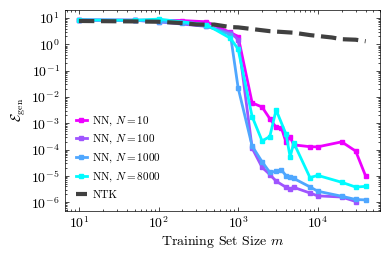

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           kernel_config: Dict[str, List],
                           training_modes: List[str] = ['ntk'],
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            kernel_config: Kernel configuration for both NTK and NNGP
            training_modes: List of kernel training modes ('ntk', 'nngp', 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            kernel_styles: Dict mapping kernel types to width styles
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
            xlabel: Custom x-axis label
            ylabel: Custom y-axis label
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot kernel results (NTK, NNGP, and Random Limit)
        for mode in training_modes:
            # Set default style based on kernel type
            if mode == 'ntk':
                default_color = self.colors['purple']
                default_linestyle = '--'
            elif mode == 'nngp':
                default_color = self.colors['green']
                default_linestyle = ':'
            else:  # random_limit
                default_color = self.colors['orange']
                default_linestyle = '-.'
                
            default_kernel_style = PlotStyle(
                color=default_color,
                linestyle=default_linestyle,
                linewidth=1.0,
                marker='o',
                markersize=3,
                label=None
            )
            
            for depth in kernel_config['depths']:
                for width in kernel_config['widths']:
                    style = (kernel_styles.get(mode, {}).get(width, default_kernel_style) 
                            if kernel_styles else default_kernel_style)
                    
                    results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                              if r.get('training_mode') == mode]
                    
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        kernel_type = {
                            'ntk': 'NTK',
                            'nngp': 'NNGP',
                            'random_limit': 'Random'
                        }.get(mode, mode.upper())
                        label = style.label if style.label is not None else f'{kernel_type} d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors,
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        kernel_config: Configuration for kernels (NTK/NNGP/Random)
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        kernel_styles: Dictionary mapping kernel types to width styles
        training_modes: List of kernel modes to plot
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
        xlabel: Custom x-axis label
        ylabel: Custom y-axis label
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles for neural networks
nn_styles = {
    10: PlotStyle(
        color="#ee00ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=10$"
    ),
    100: PlotStyle(
        color="#9f54ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=100$"
    ),
    1000: PlotStyle(
        color="#4fa7ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=1000$"
    ),
    8000: PlotStyle(
        color="#00fbff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3,
        label=r"NN, $N=8000$"
    )
}

# Define styles for kernels (NTK, NNGP, and Random Limit)
kernel_styles = {
    'ntk': {
        8000: PlotStyle(
            color=plotter.greyblack,
            linestyle='dashed',
            linewidth=3.0,
            marker='',
            markersize=2.5,
            label="NTK"
        )
    },
    # 'nngp': {
    #     8000: PlotStyle(
    #         color=plotter.GREEN,
    #         linestyle=':',
    #         linewidth=0.5,
    #         marker='s',
    #         markersize=2,
    #         label="NNGP limit"
    #     )
    # },
    # #'random_limit': {
    # #    8000: PlotStyle(
    # #        color=plotter.ORANGE,
    # #        linestyle='-.',
    # #        linewidth=0.5,
    # #        marker='^',
    # #        markersize=2,
    # #        label="Random limit"
    # #    )
    # #}
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [10, 100, 1000, 8000],
    'learning_rates': [0.05]
}

kernel_config = {
    'depths': [4],
    'widths': [8000]
}


#nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1612_nogrokk_mup_pennington"
nn_dir="/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_0701_mup_lr005"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1812_spectral/final_results_20241219_015151.json"
results_data = ResultsLoader.load_results(nn_dir, ntk_path)

# Create plot with all kernel types
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    kernel_config=kernel_config,
    nn_styles=nn_styles,
    kernel_styles=kernel_styles,
    training_modes=['ntk'],  # Include all three kernel types ['ntk', 'nngp', 'random_limit']
    figsize=(4, 2.7),
    legend_loc='lower left',
    legend_fontsize=8,
    xlabel=r'Training Set Size $m$',
    ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

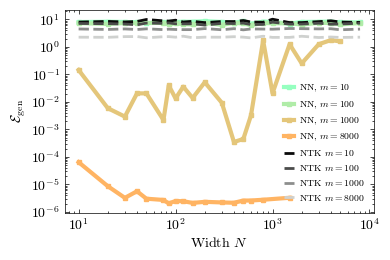

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def get_available_widths(self, results_data, result_type: str) -> List[int]:
        """Extract all unique hidden sizes (widths) from the results."""
        widths = set()
        results = results_data.filter_results(result_type)
        for r in results:
            if 'hidden_size' in r:
                widths.add(r['hidden_size'])
        return sorted(list(widths))

    def plot_width_curves(self,
                         results_data,
                         nn_config: Dict[str, List],
                         kernel_config: Dict[str, List],
                         training_modes: List[str] = ['ntk'],
                         nn_styles: Optional[Dict[int, PlotStyle]] = None,
                         kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                         figsize: Optional[Tuple[float, float]] = None,
                         legend_loc: str = 'upper right',
                         legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                         legend_fontsize: Optional[float] = None,
                         xlabel: Optional[str] = None,
                         ylabel: Optional[str] = None) -> plt.Figure:
        """Create width curves plot with customizable styles."""
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'],
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3,
            alpha=1.0
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for n_train in nn_config['n_train']:
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, n_train=n_train, learning_rate=lr
                    )
                    if results:
                        style = nn_styles.get(n_train, default_nn_style) if nn_styles else default_nn_style
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NN, n={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Plot kernel results
        for mode in training_modes:
            if mode == 'ntk':
                default_kernel_style = PlotStyle(
                    color=self.colors['greyblack'],
                    linestyle='--',
                    linewidth=2.0,
                    alpha=0.7
                )
            else:
                continue  # Skip other modes for now
            
            for depth in kernel_config['depths']:
                for n_train in nn_config['n_train']:  # Use same training sizes as NN
                    results = [r for r in results_data.filter_results('kernel', depth=depth)
                             if r.get('training_mode') == mode and r.get('n_train') == n_train]
                    
                    if results:
                        style = (kernel_styles.get(mode, {}).get(n_train, default_kernel_style) 
                                if kernel_styles else default_kernel_style)
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NTK m={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'$\mathcal{E}_{\mathrm{gen}}$', labelpad=2)
        
        # Add text box with depth and learning rate
        # ax.text(0.05, 0.95, 
        #         f'd={nn_config["depths"][0]}\n' + r'lr=5.0e-2',
        #         transform=ax.transAxes,
        #         verticalalignment='top',
        #         bbox=dict(facecolor='white', alpha=0.8))
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig


def create_width_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    plotter = SciencePlotter()
    
    fig = plotter.plot_width_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Example usage:
if __name__ == "__main__":
    # First get all available widths from the data
    plotter = SciencePlotter()
    
    nn_styles = {
        10: PlotStyle(
            color="#96ffc0",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=10$"
        ),
        100: PlotStyle(
            color="#b0eca8",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=100$"
        ),
        500: PlotStyle(
            color="#cad991",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=500$"
        ),
        1000: PlotStyle(
            color="#e4c67a",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=1000$"
        ),
        8000: PlotStyle(
            color="#ffb463",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=8000$"
        )
    }

    kernel_styles = {
        'ntk': {
            10: PlotStyle(
                color='#0a0a0a',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=10$"
            ),
            100: PlotStyle(
                color='#4b4c4b',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=100$"
            ),
            1000: PlotStyle(
                color='#8d8e8d',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=1000$"
            ),
            8000: PlotStyle(
                color='#cfd1cf',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=8000$"
            )
        }
    }

    nn_config = {
        'depths': [4],
        'n_train': [10,100, 1000, 8000],  # Different training sizes
        'learning_rates': [0.05]
    }

    kernel_config = {
        'depths': [4],
        'n_train': [10,100, 1000, 8000]  # Match NN training sizes
    }

    # Create plot
    fig = create_width_plot(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        training_modes=['ntk'],
        figsize=(4, 2.7),
        legend_loc='lower right',
        legend_fontsize=7,
        xlabel=r'Width $N$',
        ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
    )

    # Save plot as both PNG and SVG
    fig.savefig('width_analysis.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    fig.savefig('width_analysis.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

Loaded 573 NN results and 2346 NTK results

Experiment Configuration:
Depths: [1, 4]
Hidden sizes: [10, 20, 30, 40, 50, 75, 85, 100, 120, 150, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 8000]
Training sizes: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000, 40000]
Learning rates: [0.05]

NN Results Summary:
Depth 1:
  Mean: 1.8435
  Std:  2.7964
  Count: 253
Depth 4:
  Mean: 2.9728
  Std:  3.1073
  Count: 320

NTK Results Summary:
Depth 1:
  Mean: 6.1412
  Std:  2.1600
  Count: 1173
Depth 4:
  Mean: 5.4769
  Std:  2.6236
  Count: 1173


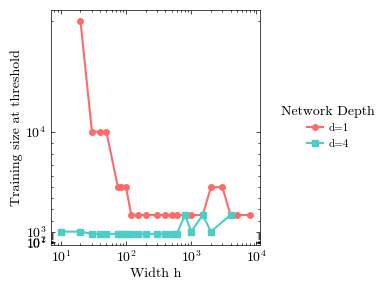

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax, x_only=False):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        if not x_only:
            ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_threshold_curves(self,
                            results_data,
                            nn_config: Dict[str, List],
                            kernel_config: Dict[str, List],
                            performance_threshold: float = 80.0,
                            depth_styles: Optional[Dict[int, PlotStyle]] = None,
                            figsize: Optional[Tuple[float, float]] = None,
                            legend_loc: str = 'upper left',
                            legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                            legend_fontsize: Optional[float] = None,
                            xlabel: Optional[str] = None,
                            ylabel: Optional[str] = None) -> plt.Figure:
        """Create threshold crossing analysis plot with customizable styles."""
        if figsize is None:
            figsize = (4, 3)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for depths
        default_depth_styles = {
            depth: PlotStyle(
                color='#1f77b4',  # blue
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=4,
                alpha=1.0,
                label=f'd={depth}'
            )
            for depth in nn_config['depths']
        }
        
        # Plot threshold data for each depth
        for depth in nn_config['depths']:
            threshold_data = []  # Store (hidden_size, crossing_point) pairs
            
            for hidden_size in nn_config['width_range']:
                # Get NTK results for this configuration
                ntk_errors_dict = {}
                ntk_results = results_data.filter_results('kernel', depth=depth, hidden_size=hidden_size)
                for r in ntk_results:
                    if r.get('training_mode') == 'ntk' and r.get('status') == 'success':
                        ntk_errors_dict[r['n_train']] = r['test_error']
                
                # Get NN results
                nn_results = results_data.filter_results(
                    'nn', depth=depth, hidden_size=hidden_size, learning_rate=nn_config['learning_rates'][0]
                )
                
                if nn_results:
                    # Sort by training size
                    nn_points = sorted([(r['n_train'], r['test_error']) for r in nn_results])
                    
                    # Find first threshold crossing
                    for train_size, nn_error in nn_points:
                        ntk_error = ntk_errors_dict.get(train_size)
                        if ntk_error is not None:
                            if nn_error <= ntk_error * (100 - performance_threshold) / 100:
                                threshold_data.append((hidden_size, train_size))
                                break
            
            if threshold_data:
                style = depth_styles.get(depth, default_depth_styles[depth]) if depth_styles else default_depth_styles[depth]
                hidden_widths, crossing_points = zip(*sorted(threshold_data))
                
                ax.plot(hidden_widths, crossing_points,
                       color=style.color,
                       linestyle=style.linestyle,
                       linewidth=style.linewidth,
                       marker=style.marker,
                       markersize=style.markersize,
                       alpha=style.alpha,
                       label=style.label)
        
        # Configure axes
        self.configure_log_axes(ax, x_only=True)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'Training size at threshold', labelpad=2)
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.5,
            'handletextpad': 0.5,
            'title': 'Network Depth'
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig

def create_plot(results_data):
    # Define styles for depths
    depth_styles = {
        1: PlotStyle(
            color='#FF6B6B',  # Coral red for depth 1
            linestyle='-',
            linewidth=1.5,
            marker='o',
            markersize=4,
            label='d=1'
        ),
        4: PlotStyle(
            color='#4ECDC4',  # Turquoise for depth 4
            linestyle='-',
            linewidth=1.5,
            marker='s',  # Square marker for distinction
            markersize=4,
            label='d=4'
        )
    }

    # Get all available widths from the data
    all_widths = set()
    for result in results_data.filter_results('nn'):
        if 'hidden_size' in result:
            all_widths.add(result['hidden_size'])
    width_range = sorted(list(all_widths))

    # Define configurations
    nn_config = {
        'depths': [1, 4],
        'width_range': width_range,
        'learning_rates': [0.05]
    }

    kernel_config = {
        'depths': [1, 4]
    }

    plotter = SciencePlotter()
    fig = plotter.plot_threshold_curves(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        performance_threshold=90.0,
        depth_styles=depth_styles,
        figsize=(4, 3),
        legend_loc='center left',
        legend_bbox_to_anchor=(1.05, 0.5),
        legend_fontsize=8,
        xlabel='Width h',
        ylabel='Training size at threshold'
    )
    
    return fig

def main():
    # Load the results using the ResultsLoader
    results_data = load_and_analyze_results(
        nn_dir,
        ntk_path
    )
    
    # Create and save the plot
    fig = create_plot(results_data)
    
    fig.savefig('threshold_crossing.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('threshold_crossing.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

# Define paths
  # Replace with your actual path

if __name__ == "__main__":
    main()

In [18]:
##### polynmoial

Loaded 827 NN results and 2484 NTK results


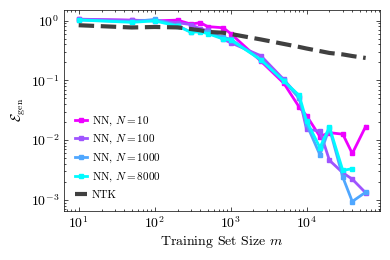

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None  # Custom label field

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        
        # Define default color schemes
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            
            # Font settings
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            
            # Axis settings
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            
            # Tick settings
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            
            # Grid settings
            'grid.linewidth': 0.5,
            
            # Line settings
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            
            # Legend settings
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_training_curves(self,
                           results_data: ResultsData,
                           nn_config: Dict[str, List],
                           kernel_config: Dict[str, List],
                           training_modes: List[str] = ['ntk'],
                           nn_styles: Optional[Dict[int, PlotStyle]] = None,
                           kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                           figsize: Optional[Tuple[float, float]] = None,
                           legend_loc: str = 'upper right',
                           legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                           legend_fontsize: Optional[float] = None,
                           xlabel: Optional[str] = None,
                           ylabel: Optional[str] = None) -> plt.Figure:
        """
        Create training curves plot with customizable legend.
        
        Args:
            results_data: ResultsData object
            nn_config: Neural network configuration
            kernel_config: Kernel configuration for both NTK and NNGP
            training_modes: List of kernel training modes ('ntk', 'nngp', 'random_limit')
            nn_styles: Dict mapping widths to PlotStyle objects for NN curves
            kernel_styles: Dict mapping kernel types to width styles
            figsize: Optional figure size
            legend_loc: Location of the legend ('upper right', 'center left', etc.)
            legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
            legend_fontsize: Font size for legend text
            xlabel: Custom x-axis label
            ylabel: Custom y-axis label
        """
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'], 
            linestyle='-', 
            linewidth=1.0,
            marker='o',
            markersize=3,
            label=None
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for width in nn_config['widths']:
                style = nn_styles.get(width, default_nn_style) if nn_styles else default_nn_style
                
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, hidden_size=width, learning_rate=lr
                    )
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        label = style.label if style.label is not None else f'NN d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors, 
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Plot kernel results (NTK, NNGP, and Random Limit)
        for mode in training_modes:
            # Set default style based on kernel type
            if mode == 'ntk':
                default_color = self.colors['purple']
                default_linestyle = '--'
            elif mode == 'nngp':
                default_color = self.colors['green']
                default_linestyle = ':'
            else:  # random_limit
                default_color = self.colors['orange']
                default_linestyle = '-.'
                
            default_kernel_style = PlotStyle(
                color=default_color,
                linestyle=default_linestyle,
                linewidth=1.0,
                marker='o',
                markersize=3,
                label=None
            )
            
            for depth in kernel_config['depths']:
                for width in kernel_config['widths']:
                    style = (kernel_styles.get(mode, {}).get(width, default_kernel_style) 
                            if kernel_styles else default_kernel_style)
                    
                    results = [r for r in results_data.filter_results('kernel', depth=depth, hidden_size=width)
                              if r.get('training_mode') == mode]
                    
                    if results:
                        sorted_results = sorted(results, key=lambda x: x['n_train'])
                        train_sizes = [r['n_train'] for r in sorted_results]
                        errors = [r['test_error'] for r in sorted_results]
                        
                        # Use custom label if provided, otherwise use default
                        kernel_type = {
                            'ntk': 'NTK',
                            'nngp': 'NNGP',
                            'random_limit': 'Random'
                        }.get(mode, mode.upper())
                        label = style.label if style.label is not None else f'{kernel_type} d={depth},h={width}'
                        
                        ax.plot(train_sizes, errors,
                               color=style.color,
                               linestyle=style.linestyle,
                               linewidth=style.linewidth,
                               marker=style.marker,
                               markersize=style.markersize,
                               alpha=style.alpha,
                               label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else 'Training Size', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else 'Test Error', labelpad=2)
        
        # Add legend with customizable position and size
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
            
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        
        plt.tight_layout()
        return fig


def create_training_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    """
    Create a training plot with specified configurations and styles.
    
    Args:
        results_data: The loaded results data
        nn_config: Configuration for neural networks
        kernel_config: Configuration for kernels (NTK/NNGP/Random)
        nn_styles: Dictionary mapping widths to PlotStyle objects for NN
        kernel_styles: Dictionary mapping kernel types to width styles
        training_modes: List of kernel modes to plot
        figsize: Optional figure size
        legend_loc: Location of the legend
        legend_bbox_to_anchor: Tuple of (x, y) coordinates for legend position
        legend_fontsize: Font size for legend text
        xlabel: Custom x-axis label
        ylabel: Custom y-axis label
    """
    plotter = SciencePlotter()
    
    # Create the plot
    fig = plotter.plot_training_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Usage example:
plotter = SciencePlotter()

# Define styles for neural networks
nn_styles = {
    10: PlotStyle(
        color="#ee00ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=10$"
    ),
    100: PlotStyle(
        color="#9f54ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=100$"
    ),
    1000: PlotStyle(
        color="#4fa7ff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3.0,
        label=r"NN, $N=1000$"
    ),
    8000: PlotStyle(
        color="#00fbff",
        linestyle='-',
        linewidth=2.0,
        marker='s',
        markersize=3,
        label=r"NN, $N=8000$"
    )
}

# Define styles for kernels (NTK, NNGP, and Random Limit)
kernel_styles = {
    'ntk': {
        8000: PlotStyle(
            color=plotter.greyblack,
            linestyle='dashed',
            linewidth=3.0,
            marker='',
            markersize=2.5,
            label="NTK"
        )
    },
    # 'nngp': {
    #     8000: PlotStyle(
    #         color=plotter.GREEN,
    #         linestyle=':',
    #         linewidth=0.5,
    #         marker='s',
    #         markersize=2,
    #         label="NNGP limit"
    #     )
    # },
    # #'random_limit': {
    # #    8000: PlotStyle(
    # #        color=plotter.ORANGE,
    # #        linestyle='-.',
    # #        linewidth=0.5,
    # #        marker='^',
    # #        markersize=2,
    # #        label="Random limit"
    # #    )
    # #}
}

# Define configurations
nn_config = {
    'depths': [4],
    'widths': [10, 100,1000, 8000],
    'learning_rates': [0.001]
}

kernel_config = {
    'depths': [4],
    'widths': [8000]
}


nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_NN_2812_mup_lr0001"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
results_data = ResultsLoader.load_results(nn_dir, ntk_path)

# Create plot with all kernel types
fig = create_training_plot(
    results_data=results_data,
    nn_config=nn_config,
    kernel_config=kernel_config,
    nn_styles=nn_styles,
    kernel_styles=kernel_styles,
    training_modes=['ntk'],  # Include all three kernel types ['ntk', 'nngp', 'random_limit']
    figsize=(4, 2.7),
    legend_loc='lower left',
    legend_fontsize=8,
    xlabel=r'Training Set Size $m$',
    ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
)

# Save plot as both PNG and SVG
fig.savefig('training_curves.png', 
            dpi=300, 
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

fig.savefig('training_curves.svg',
            bbox_inches='tight',
            facecolor='white',
            edgecolor='black')

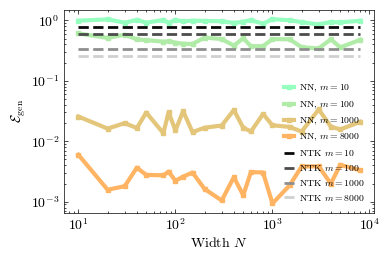

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
from typing import Dict, List, Optional, Tuple, Union
from dataclasses import dataclass
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'greyblack': self.greyblack
        }
    
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def get_available_widths(self, results_data, result_type: str) -> List[int]:
        """Extract all unique hidden sizes (widths) from the results."""
        widths = set()
        results = results_data.filter_results(result_type)
        for r in results:
            if 'hidden_size' in r:
                widths.add(r['hidden_size'])
        return sorted(list(widths))

    def plot_width_curves(self,
                         results_data,
                         nn_config: Dict[str, List],
                         kernel_config: Dict[str, List],
                         training_modes: List[str] = ['ntk'],
                         nn_styles: Optional[Dict[int, PlotStyle]] = None,
                         kernel_styles: Optional[Dict[str, Dict[int, PlotStyle]]] = None,
                         figsize: Optional[Tuple[float, float]] = None,
                         legend_loc: str = 'upper right',
                         legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                         legend_fontsize: Optional[float] = None,
                         xlabel: Optional[str] = None,
                         ylabel: Optional[str] = None) -> plt.Figure:
        """Create width curves plot with customizable styles."""
        if figsize is None:
            figsize = (3.3, 2.5)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for neural networks
        default_nn_style = PlotStyle(
            color=self.colors['blue'],
            linestyle='-',
            linewidth=2.0,
            marker='s',
            markersize=3,
            alpha=1.0
        )
        
        # Plot NN results
        for depth in nn_config['depths']:
            for n_train in nn_config['n_train']:
                for lr in nn_config['learning_rates']:
                    results = results_data.filter_results(
                        'nn', depth=depth, n_train=n_train, learning_rate=lr
                    )
                    if results:
                        style = nn_styles.get(n_train, default_nn_style) if nn_styles else default_nn_style
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NN, n={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Plot kernel results
        for mode in training_modes:
            if mode == 'ntk':
                default_kernel_style = PlotStyle(
                    color=self.colors['greyblack'],
                    linestyle='--',
                    linewidth=2.0,
                    alpha=0.7
                )
            else:
                continue  # Skip other modes for now
            
            for depth in kernel_config['depths']:
                for n_train in nn_config['n_train']:  # Use same training sizes as NN
                    results = [r for r in results_data.filter_results('kernel', depth=depth)
                             if r.get('training_mode') == mode and r.get('n_train') == n_train]
                    
                    if results:
                        style = (kernel_styles.get(mode, {}).get(n_train, default_kernel_style) 
                                if kernel_styles else default_kernel_style)
                        
                        # Group by width and get test errors
                        width_errors = {}
                        for r in results:
                            width = r['hidden_size']
                            if width not in width_errors:
                                width_errors[width] = r['test_error']
                        
                        if width_errors:
                            widths, errors = zip(*sorted(width_errors.items()))
                            
                            label = style.label if style.label is not None else f'NTK m={n_train}'
                            ax.plot(widths, errors,
                                   color=style.color,
                                   linestyle=style.linestyle,
                                   linewidth=style.linewidth,
                                   marker=style.marker,
                                   markersize=style.markersize,
                                   alpha=style.alpha,
                                   label=label)
        
        # Configure log axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'$\mathcal{E}_{\mathrm{gen}}$', labelpad=2)
        
        # Add text box with depth and learning rate
        # ax.text(0.05, 0.95, 
        #         f'd={nn_config["depths"][0]}\n' + r'lr=5.0e-2',
        #         transform=ax.transAxes,
        #         verticalalignment='top',
        #         bbox=dict(facecolor='white', alpha=0.8))
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.0,
            'handletextpad': 0.5
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig


def create_width_plot(
    results_data,
    nn_config: dict,
    kernel_config: dict,
    nn_styles: dict,
    kernel_styles: dict,
    training_modes: List[str] = ['ntk'],
    figsize: Optional[Tuple[float, float]] = None,
    legend_loc: str = 'upper right',
    legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
    legend_fontsize: Optional[float] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None
):
    plotter = SciencePlotter()
    
    fig = plotter.plot_width_curves(
        results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        training_modes=training_modes,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        figsize=figsize,
        legend_loc=legend_loc,
        legend_bbox_to_anchor=legend_bbox_to_anchor,
        legend_fontsize=legend_fontsize,
        xlabel=xlabel,
        ylabel=ylabel
    )
    
    return fig

# Example usage:
if __name__ == "__main__":
    # First get all available widths from the data
    plotter = SciencePlotter()
    
    nn_styles = {
        100: PlotStyle(
            color="#96ffc0",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=10$"
        ),
        1000: PlotStyle(
            color="#b0eca8",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=100$"
        ),
        500: PlotStyle(
            color="#cad991",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=500$"
        ),
        10000: PlotStyle(
            color="#e4c67a",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=1000$"
        ),
        40000: PlotStyle(
            color="#ffb463",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=8000$"
        ),
        60000: PlotStyle(
            color="#ffb463",  # Light blue
            linestyle='-',
            linewidth=3.0,
            marker='s',
            markersize=2.5,
            label=r"NN, $m=8000$"
        )
    }

    kernel_styles = {
        'ntk': {
            100: PlotStyle(
                color='#0a0a0a',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=10$"
            ),
            1000: PlotStyle(
                color='#4b4c4b',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=100$"
            ),
            10000: PlotStyle(
                color='#8d8e8d',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=1000$"
            ),
            40000: PlotStyle(
                color='#cfd1cf',  # Grey
                linestyle='--',
                linewidth=2.0,
                marker='',
                markersize=0,
                label="NTK $m=8000$"
            )
        }
    }

    nn_config = {
        'depths': [4],
        'n_train': [100, 1000,10000, 40000],  # Different training sizes
        'learning_rates': [0.001]
    }

    kernel_config = {
        'depths': [4],
        'n_train': [100, 1000, 10000,40000]  # Match NN training sizes
    }

    # Create plot
    fig = create_width_plot(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        nn_styles=nn_styles,
        kernel_styles=kernel_styles,
        training_modes=['ntk'],
        figsize=(4, 2.7),
        legend_loc='lower right',
        legend_fontsize=7,
        xlabel=r'Width $N$',
        ylabel=r'$\mathcal{E}_{\mathrm{gen}}$'
    )

    # Save plot as both PNG and SVG
    fig.savefig('width_analysis.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

    fig.savefig('width_analysis.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

Loaded 827 NN results and 2484 NTK results

Experiment Configuration:
Depths: [1, 4]
Hidden sizes: [10, 20, 30, 40, 50, 75, 85, 100, 120, 150, 200, 300, 400, 500, 600, 800, 1000, 1500, 2000, 3000, 4000, 5000, 8000]
Training sizes: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000, 40000, 60000]
Learning rates: [0.001]

NN Results Summary:
Depth 1:
  Mean: 0.5382
  Std:  0.4527
  Count: 414
Depth 4:
  Mean: 0.4163
  Std:  0.3989
  Count: 413

NTK Results Summary:
Depth 1:
  Mean: 0.7981
  Std:  0.1805
  Count: 1242
Depth 4:
  Mean: 0.6296
  Std:  0.2289
  Count: 1242


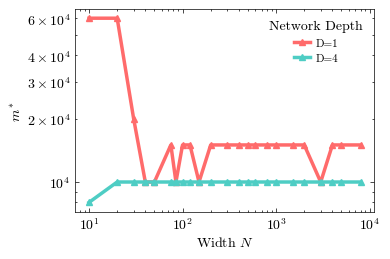

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from cycler import cycler
from pathlib import Path

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class SciencePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GRAY = '#808080'
    greyblack = '#404040'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'gray': self.GRAY,
            'greyblack': self.greyblack
        }
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax, x_only=False):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        if not x_only:
            ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_threshold_curves(self,
                            results_data,
                            nn_config: Dict[str, List],
                            kernel_config: Dict[str, List],
                            performance_threshold: float = 80.0,
                            depth_styles: Optional[Dict[int, PlotStyle]] = None,
                            figsize: Optional[Tuple[float, float]] = None,
                            legend_loc: str = 'upper left',
                            legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                            legend_fontsize: Optional[float] = None,
                            xlabel: Optional[str] = None,
                            ylabel: Optional[str] = None) -> plt.Figure:
        """Create threshold crossing analysis plot with customizable styles."""
        if figsize is None:
            figsize = (4, 3)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for depths
        default_depth_styles = {
            depth: PlotStyle(
                color='#1f77b4',
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=4,
                alpha=1.0,
                label=f'd={depth}'
            )
            for depth in nn_config['depths']
        }
        
        # Plot threshold data for each depth
        for depth in nn_config['depths']:
            threshold_data = []  # Store (hidden_size, crossing_point) pairs
            
            for hidden_size in nn_config['width_range']:
                # Get NTK results for this configuration
                ntk_errors_dict = {}
                ntk_results = results_data.filter_results('kernel', depth=depth, hidden_size=hidden_size)
                for r in ntk_results:
                    if r.get('training_mode') == 'ntk' and r.get('status') == 'success':
                        ntk_errors_dict[r['n_train']] = r['test_error']
                
                # Get NN results
                nn_results = results_data.filter_results(
                    'nn', depth=depth, hidden_size=hidden_size, learning_rate=nn_config['learning_rates'][0]
                )
                
                if nn_results:
                    # Sort by training size
                    nn_points = sorted([(r['n_train'], r['test_error']) for r in nn_results])
                    crossing_found = False
                    
                    # Try to find threshold crossing
                    for train_size, nn_error in nn_points:
                        ntk_error = ntk_errors_dict.get(train_size)
                        if ntk_error is not None:
                            if nn_error <= ntk_error * (100 - performance_threshold) / 100:
                                threshold_data.append((hidden_size, train_size))
                                crossing_found = True
                                break
                    
                    # If no crossing found, use the highest training size
                    if not crossing_found and nn_points:
                        max_train_size = max(p[0] for p in nn_points)
                        threshold_data.append((hidden_size, max_train_size))
            
            if threshold_data:
                style = depth_styles.get(depth, default_depth_styles[depth]) if depth_styles else default_depth_styles[depth]
                hidden_widths, crossing_points = zip(*sorted(threshold_data))
                
                ax.plot(hidden_widths, crossing_points,
                       color=style.color,
                       linestyle=style.linestyle,
                       linewidth=style.linewidth,
                       marker=style.marker,
                       markersize=style.markersize,
                       alpha=style.alpha,
                       label=style.label)
        
        # Configure axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Width $h$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'Training size at threshold', labelpad=2)
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.5,
            'handletextpad': 0.5,
            'title': 'Network Depth'
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig

def create_plot(results_data):
    # Define styles for depths
    depth_styles = {
        1: PlotStyle(
            color='#FF6B6B',  # Coral red for depth 1
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='D=1'
        ),
        4: PlotStyle(
            color='#4ECDC4',  # Turquoise for depth 4
            linestyle='-',
            linewidth=2.5,
            marker='^',  # Square marker for distinction
            markersize=4,
            label='D=4'
        )
    }

    # Get all available widths from the data
    all_widths = set()
    for result in results_data.filter_results('nn'):
        if 'hidden_size' in result:
            all_widths.add(result['hidden_size'])
    width_range = sorted(list(all_widths))

    # Define configurations
    nn_config = {
        'depths': [1, 4],
        'width_range': width_range,
        'learning_rates': [0.001]
    }

    kernel_config = {
        'depths': [1, 4]
    }

    plotter = SciencePlotter()
    fig = plotter.plot_threshold_curves(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        performance_threshold=90.0,
        depth_styles=depth_styles,
        figsize=(4, 2.7),
        legend_loc='upper right',
        legend_bbox_to_anchor=(1.0, 1.0),
        legend_fontsize=8,
        xlabel=r'Width $N$',
        ylabel=r'$m^*$'
    )
    
    return fig

def main():
    # Load the results using the ResultsLoader
    results_data = load_and_analyze_results(
        nn_dir,
        ntk_path
    )
    
    # Create and save the plot
    fig = create_plot(results_data)
    
    fig.savefig('threshold_crossing.png', 
                dpi=300, 
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')
    
    fig.savefig('threshold_crossing.svg',
                bbox_inches='tight',
                facecolor='white',
                edgecolor='black')

# Define paths
nn_dir = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/low_dim_poly_NN_2812_mup_lr0001"
ntk_path = "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"

if __name__ == "__main__":
    main()

In [ ]:
### learning rate

Loaded 382 NN results and 2484 NTK results

Experiment Configuration:
Depths: [1, 4]
Hidden sizes: [800, 5000, 8000]
Training sizes: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000, 40000]
Learning rates: [1e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1]

NN Results Summary:
Depth 1:
  Mean: 46151.5526
  Std:  570435.3074
  Count: 158
Depth 4:
  Mean: 29.7792
  Std:  319.9168
  Count: 224

NTK Results Summary:
Depth 1:
  Mean: 0.7981
  Std:  0.1805
  Count: 1242
Depth 4:
  Mean: 0.6296
  Std:  0.2289
  Count: 1242


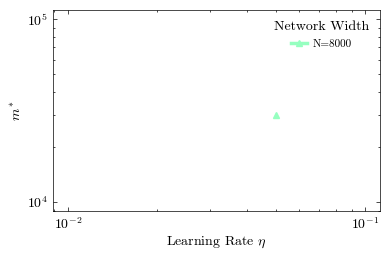

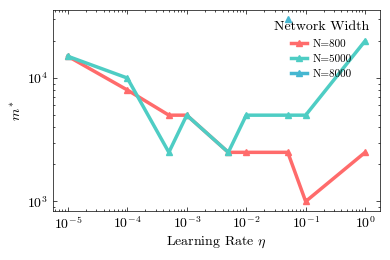

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from cycler import cycler

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class LearningRatePlotter:
    # Define colors for different widths
    COLORS = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96FFC0', '#FFB463']
    
    def __init__(self):
        self.setup_science_style()
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_lr_threshold_curves(self,
                               results_data,
                               depth: int,
                               widths: List[int],
                               performance_threshold: float = 80.0,
                               width_styles: Optional[Dict[int, PlotStyle]] = None,
                               figsize: Optional[Tuple[float, float]] = None,
                               legend_loc: str = 'upper left',
                               legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                               legend_fontsize: Optional[float] = None) -> plt.Figure:
        """Create threshold crossing analysis plot against learning rate for different widths."""
        if figsize is None:
            figsize = (4, 3)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for widths
        default_width_styles = {
            width: PlotStyle(
                color=self.COLORS[i % len(self.COLORS)],
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=4,
                alpha=1.0,
                label=f'N={width}'
            )
            for i, width in enumerate(widths)
        }
        
        # Get all available learning rates
        all_lrs = set()
        for result in results_data.filter_results('nn', depth=depth):
            lr = result.get('learning_rate', result.get('lr'))
            if lr is not None:
                all_lrs.add(lr)
        learning_rates = sorted(list(all_lrs))
        
        # Plot threshold data for each width
        for width in widths:
            threshold_data = []  # Store (lr, crossing_point) pairs
            
            # Get NTK results for this configuration
            ntk_errors_dict = {}
            ntk_results = results_data.filter_results('ntk', depth=depth, hidden_size=width)
            for r in ntk_results:
                if r.get('training_mode') == 'ntk' and r.get('status') == 'success':
                    ntk_errors_dict[r['n_train']] = r['test_error']
            
            for lr in learning_rates:
                # Get NN results
                nn_results = results_data.filter_results(
                    'nn', depth=depth, hidden_size=width, learning_rate=lr
                )
                
                if nn_results:
                    # Sort by training size
                    nn_points = sorted([(r['n_train'], r['test_error']) for r in nn_results])
                    crossing_found = False
                    
                    # Try to find threshold crossing
                    for train_size, nn_error in nn_points:
                        ntk_error = ntk_errors_dict.get(train_size)
                        if ntk_error is not None:
                            if nn_error <= ntk_error * (100 - performance_threshold) / 100:
                                threshold_data.append((lr, train_size))
                                crossing_found = True
                                break
                    
                    # If no crossing found, use the highest training size
                    if not crossing_found and nn_points:
                        max_train_size = max(p[0] for p in nn_points)
                        threshold_data.append((lr, max_train_size))
            
            if threshold_data:
                style = width_styles.get(width, default_width_styles[width]) if width_styles else default_width_styles[width]
                lrs, crossing_points = zip(*sorted(threshold_data))
                
                ax.plot(lrs, crossing_points,
                       color=style.color,
                       linestyle=style.linestyle,
                       linewidth=style.linewidth,
                       marker=style.marker,
                       markersize=style.markersize,
                       alpha=style.alpha,
                       label=style.label)
        
        # Configure axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(r'Learning Rate $\eta$', labelpad=2)
        ax.set_ylabel(r'$m^*$', labelpad=2)
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.5,
            'handletextpad': 0.5,
            'title': 'Network Width'
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig

def create_lr_plot(results_data, depth=4, widths=[10, 100, 1000, 8000]):
    # Create custom styles for different widths if desired
    width_styles = {
        width: PlotStyle(
            color=LearningRatePlotter.COLORS[i % len(LearningRatePlotter.COLORS)],
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label=f'N={width}'
        )
        for i, width in enumerate(widths)
    }

    plotter = LearningRatePlotter()
    fig = plotter.plot_lr_threshold_curves(
        results_data=results_data,
        depth=depth,
        widths=widths,
        performance_threshold=90.0,
        width_styles=width_styles,
        figsize=(4, 2.7),
        legend_loc='upper right',
        legend_bbox_to_anchor=(1.0, 1.0),
        legend_fontsize=8
    )
    
    return fig

# Example usage:
def plot_lr_analysis(results_data, depth=4, widths=[10, 100, 1000, 8000], save=True):
    """
    Create and optionally save the learning rate analysis plot.
    
    Args:
        results_data: The loaded results data object
        depth: The network depth to analyze (default: 4)
        widths: List of widths to plot (default: [10, 100, 1000, 8000])
        save: Whether to save the plot to files (default: True)
    
    Returns:
        The created figure object
    """
    fig = create_lr_plot(results_data, depth=depth, widths=widths)
    
    if save:
        fig.savefig('lr_threshold_crossing.png', 
                    dpi=300, 
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
        
        fig.savefig('lr_threshold_crossing.svg',
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
    
    return fig


# Assuming you've already loaded your results_data using the ResultsLoader
results_data = load_and_analyze_results(
        "/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1201_mup_lr_grid",
        "/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
    )


# Create the plot with default settings (depth=4, widths=[10, 100, 1000, 8000])
fig = plot_lr_analysis(results_data)

# Or customize the depth and widths
fig = plot_lr_analysis(
    results_data,
    depth=4,  # Change this to analyze different depths
    widths=[800, 5000, 8000],  # Modify this list to analyze different widths
    save=True  # Set to False if you don't want to save files
)

# Display the plot in the notebook
plt.show()

Loaded 3451 NN results and 2484 NTK results

Experiment Configuration:
Depths: [1, 4]
Hidden sizes: [10, 50, 75, 100, 200, 400, 500, 800, 1000, 2000, 3000, 5000, 8000]
Training sizes: [10, 50, 100, 200, 300, 400, 500, 800, 1000, 2500, 5000, 8000, 10000, 15000, 20000, 30000, 40000]
Learning rates: [1e-05, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1]

NN Results Summary:
Depth 1:
  Mean: 19077.8228
  Std:  580411.6585
  Count: 1688
Depth 4:
  Mean: 27.1208
  Std:  478.9117
  Count: 1763

NTK Results Summary:
Depth 1:
  Mean: 0.7981
  Std:  0.1805
  Count: 1242
Depth 4:
  Mean: 0.6296
  Std:  0.2289
  Count: 1242


KeyError: 2000

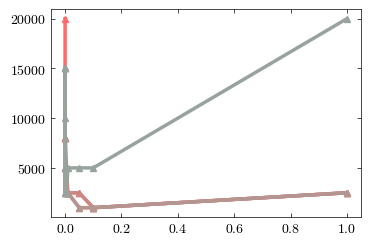

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from cycler import cycler

@dataclass
class PlotStyle:
    color: str
    linestyle: str
    linewidth: float
    marker: Optional[str] = None
    markersize: Optional[float] = None
    alpha: float = 1.0
    label: Optional[str] = None

class LearningRatePlotter:
    # Define colors as class attributes
    PURPLE = '#8710FF'
    BLUE = '#01B5EB'
    GREEN = '#96FFC0'
    ORANGE = '#FFB463'
    RED = '#FF0000'
    GRAY = '#808080'
    
    def __init__(self):
        self.setup_science_style()
        self.colors = {
            'purple': self.PURPLE,
            'blue': self.BLUE,
            'green': self.GREEN,
            'orange': self.ORANGE,
            'red': self.RED,
            'gray': self.GRAY
        }
        
    @staticmethod
    def setup_science_style():
        """Set up consistent science styling with proper log-scale ticks."""
        plt.style.use('default')
        mpl.rcParams.update({
            'figure.figsize': (3.3, 2.5),
            'figure.dpi': 100,
            'font.family': 'serif',
            'font.serif': ['cmr10', 'Computer Modern Serif', 'DejaVu Serif'],
            'text.usetex': False,
            'axes.formatter.use_mathtext': True,
            'mathtext.fontset': 'cm',
            'axes.linewidth': 0.5,
            'axes.spines.top': True,
            'axes.spines.right': True,
            'axes.spines.left': True,
            'axes.spines.bottom': True,
            'xtick.direction': 'in',
            'ytick.direction': 'in',
            'xtick.major.width': 0.5,
            'ytick.major.width': 0.5,
            'xtick.minor.width': 0.5,
            'ytick.minor.width': 0.5,
            'xtick.major.size': 3,
            'ytick.major.size': 3,
            'xtick.minor.size': 1.5,
            'ytick.minor.size': 1.5,
            'xtick.top': True,
            'ytick.right': True,
            'grid.linewidth': 0.5,
            'lines.linewidth': 1.0,
            'lines.markersize': 3,
            'legend.frameon': False,
            'legend.borderpad': 0,
            'legend.borderaxespad': 1.0,
            'legend.handlelength': 1.0,
            'legend.handletextpad': 0.5,
        })

    def configure_log_axes(self, ax):
        """Configure axes for proper log scale appearance."""
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.minorticks_on()
        
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_formatter(mpl.ticker.LogFormatterSciNotation())
            axis.set_major_locator(mpl.ticker.LogLocator(numticks=15))
            axis.set_minor_locator(mpl.ticker.LogLocator(subs=np.arange(2, 10), numticks=15))
            axis.set_tick_params(which='both', direction='in')

    def plot_threshold_curves(self,
                            results_data,
                            nn_config: Dict[str, List],
                            kernel_config: Dict[str, List],
                            performance_threshold: float = 80.0,
                            width_styles: Optional[Dict[int, PlotStyle]] = None,
                            figsize: Optional[Tuple[float, float]] = None,
                            legend_loc: str = 'upper left',
                            legend_bbox_to_anchor: Optional[Tuple[float, float]] = None,
                            legend_fontsize: Optional[float] = None,
                            xlabel: Optional[str] = None,
                            ylabel: Optional[str] = None) -> plt.Figure:
        """Create threshold crossing analysis plot against learning rate for different widths."""
        if figsize is None:
            figsize = (4, 3)
            
        fig, ax = plt.subplots(figsize=figsize)
        
        # Default style for widths if not provided
        default_width_styles = {
            width: PlotStyle(
                color=list(self.colors.values())[i % len(self.colors)],
                linestyle='-',
                linewidth=1.5,
                marker='o',
                markersize=4,
                alpha=1.0,
                label=f'N={width}'
            )
            for i, width in enumerate(nn_config['widths'])
        }
        
        width_styles = width_styles or default_width_styles
        
        # Plot threshold data for each width
        for width in nn_config['widths']:
            threshold_data = []  # Store (lr, crossing_point) pairs
            
            # Get NTK results for this configuration
            ntk_errors_dict = {}
            ntk_results = results_data.filter_results('ntk', depth=nn_config['depth'], hidden_size=width)
            for r in ntk_results:
                if r.get('training_mode') == 'ntk' and r.get('status') == 'success':
                    ntk_errors_dict[r['n_train']] = r['test_error']
            
            for lr in nn_config['learning_rates']:
                # Get NN results
                nn_results = results_data.filter_results(
                    'nn', depth=nn_config['depth'], hidden_size=width, learning_rate=lr
                )
                
                if nn_results:
                    # Sort by training size
                    nn_points = sorted([(r['n_train'], r['test_error']) for r in nn_results])
                    crossing_found = False
                    
                    # Try to find threshold crossing
                    for train_size, nn_error in nn_points:
                        ntk_error = ntk_errors_dict.get(train_size)
                        if ntk_error is not None:
                            if nn_error <= ntk_error * (100 - performance_threshold) / 100:
                                threshold_data.append((lr, train_size))
                                crossing_found = True
                                break
                    
                    # If no crossing found, use the highest training size
                    if not crossing_found and nn_points:
                        max_train_size = max(p[0] for p in nn_points)
                        threshold_data.append((lr, max_train_size))
            
            if threshold_data:
                style = width_styles[width]
                lrs, crossing_points = zip(*sorted(threshold_data))
                
                ax.plot(lrs, crossing_points,
                       color=style.color,
                       linestyle=style.linestyle,
                       linewidth=style.linewidth,
                       marker=style.marker,
                       markersize=style.markersize,
                       alpha=style.alpha,
                       label=style.label)
        
        # Configure axes
        self.configure_log_axes(ax)
        
        # Set labels
        ax.set_xlabel(xlabel if xlabel is not None else r'Learning Rate $\eta$', labelpad=2)
        ax.set_ylabel(ylabel if ylabel is not None else r'$m^*$', labelpad=2)
        
        # Configure legend
        legend_kwargs = {
            'frameon': False,
            'loc': legend_loc,
            'handlelength': 1.5,
            'handletextpad': 0.5,
            'title': 'Network Width'
        }
        
        if legend_bbox_to_anchor is not None:
            legend_kwargs['bbox_to_anchor'] = legend_bbox_to_anchor
        if legend_fontsize is not None:
            legend_kwargs['fontsize'] = legend_fontsize
            
        ax.legend(**legend_kwargs)
        plt.tight_layout()
        return fig

def create_plot(results_data):
    # Define styles for widths
    width_styles = {
        10: PlotStyle(
            color='#FF6B6B',  # Coral red
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=10'
        ),
        100: PlotStyle(
            color='#4ECDC4',  # Turquoise
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=100'
        ),
        1000: PlotStyle(
            color='#45B7D1',  # Blue
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=1000'
        ),
        8000: PlotStyle(
            color='#96FFC0',  # Green
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=8000'
        )
    }

    # Get all available learning rates from the data
    all_lrs = set()
    for result in results_data.filter_results('nn'):
        lr = result.get('learning_rate', result.get('lr'))
        if lr is not None:
            all_lrs.add(lr)
    learning_rates = sorted(list(all_lrs))

    # Define configurations
    nn_config = {
        'depth': 4,  # Fixed depth for this analysis
        'widths': [10, 100, 1000, 8000],
        'learning_rates': learning_rates
    }

    kernel_config = {
        'depth': 4
    }

    plotter = LearningRatePlotter()
    fig = plotter.plot_threshold_curves(
        results_data=results_data,
        nn_config=nn_config,
        kernel_config=kernel_config,
        performance_threshold=90.0,
        width_styles=width_styles,
        figsize=(4, 2.7),
        legend_loc='upper right',
        legend_bbox_to_anchor=(1.0, 1.0),
        legend_fontsize=8,
        xlabel=r'Learning Rate $\eta$',
        ylabel=r'$m^*$'
    )
    
    return fig

def plot_lr_analysis(results_data, save=True):
    """
    Create and optionally save the learning rate analysis plot.
    
    Args:
        results_data: The loaded results data object
        save: Whether to save the plot to files (default: True)
    
    Returns:
        The created figure object
    """
    fig = create_plot(results_data)
    
    if save:
        fig.savefig('lr_threshold_crossing.png', 
                    dpi=300, 
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
        
        fig.savefig('lr_threshold_crossing.svg',
                    bbox_inches='tight',
                    facecolor='white',
                    edgecolor='black')
    
    return fig



# [Previous code remains the same up until the final usage example]

# Example usage with specific paths and configurations:
if __name__ == "__main__":
    # Load the results data
    results_data = load_and_analyze_results(
        nn_dir="/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1201_mup_lr_grid",
        ntk_path="/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
    )

    # Create plot with custom width styles
    width_styles = {
         100: PlotStyle(
            color='#ff6b6b',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=100'
        ),
        500: PlotStyle(
            color='#e57977',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=500'
        ),
        
        800: PlotStyle(
            color='#cc8784',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=800'
        ),
         1000: PlotStyle(
            color='#b39591',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=1000'
        ),
        5000: PlotStyle(
            color='#99a39d',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=5000'
        ),
        3000: PlotStyle(
            color='#80b1aa',
            linestyle='-',
            linewidth=2.5,
            marker='^',
            markersize=4,
            label='N=3000'
        )
    }

    def create_plot(results_data):
        # Get all available learning rates from the data
        all_lrs = set()
        for result in results_data.filter_results('nn'):
            lr = result.get('learning_rate', result.get('lr'))
            if lr is not None:
                all_lrs.add(lr)
        learning_rates = sorted(list(all_lrs))

        # Define configurations
        nn_config = {
            'depth': 4,  # Fixed depth for this analysis
            'widths': [100,500,800,1000,5000, 2000,400,200],  # Your specified widths
            'learning_rates': learning_rates
        }

        kernel_config = {
            'depth': 4
        }

        plotter = LearningRatePlotter()
        fig = plotter.plot_threshold_curves(
            results_data=results_data,
            nn_config=nn_config,
            kernel_config=kernel_config,
            performance_threshold=90.0,
            width_styles=width_styles,
            figsize=(4, 2.7),
            legend_loc='upper right',
            legend_bbox_to_anchor=(1.0, 1.0),
            legend_fontsize=8,
            xlabel=r'Learning Rate $\eta$',
            ylabel=r'$m^*$'
        )
        
        return fig

    # Create and save the plot
    fig = plot_lr_analysis(results_data)
    
    # Display the plot
    plt.show()

# For use in a Jupyter notebook, you can copy this section:

# Load results data


results_data = load_and_analyze_results(
    nn_dir="/mnt/users/goringn/NNs_vs_Kernels/stair_function/results/msp_NN_grid_1201_mup_lr_grid",
    ntk_path="/mnt/users/goringn/NNs_vs_Kernels/low_dim_poly/results/kernel_final.json"
)

# Define width styles (copy the width_styles dictionary from above)

# Create plot with default settings
fig = plot_lr_analysis(results_data)

# Or create plot with custom settings by modifying create_plot function
# [Copy the create_plot function from above and modify as needed]

# Display the plot
plt.show()


Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 13.4MB/s]


Extracting /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw/train-images-idx3-ubyte.gz to /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 374kB/s]


Extracting /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw/train-labels-idx1-ubyte.gz to /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.49MB/s]


Extracting /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 1.81MB/s]


Extracting /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /mnt/users/goringn/NNs_vs_Kernels/cifar10/data/MNIST/raw

Loaded MNIST data:
Training: X shape=torch.Size([60000, 784]), y shape=torch.Size([60000])
Test: X shape=torch.Size([10000, 784]), y shape=torch.Size([10000])
Label distribution in training: tensor([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949])


(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([5, 0, 4,  ..., 5, 6, 8]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([7, 2, 1,  ..., 4, 5, 6]))